In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

## Готовим данные

In [2]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [3]:
data_train = read_set('train.csv')
data_test =  read_set('derived.csv')
data_sample = read_set('sample_submission.csv')

In [4]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [5]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [6]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [7]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


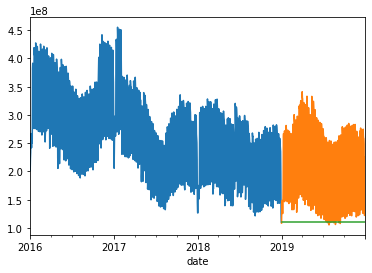

In [8]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_sample['value'].plot(kind = 'line')
plt.show()

In [323]:
arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=0.63 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=1.46 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=2.41 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.125, Time=1.81 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=3.41 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=3.21 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=2.35 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=2.14 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.291, Time=4.46 sec
 ARIMA(2,0,3)(2,0,2

In [324]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [325]:
prediction = prediction .rename(columns = {0:'value'})

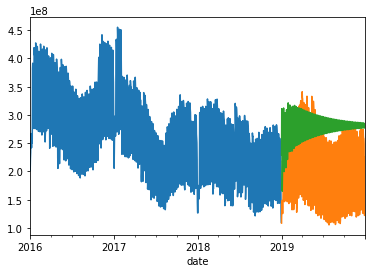

In [326]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line')
plt.show()

In [327]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

In [328]:
MAPE(data_test, prediction)

39.83962687349625

In [15]:
MAPE(data_test, data_sample)

44.81735178659308

In [16]:
m = np.mean(data_train)
std = np.std(data_train)

In [17]:
np.mean( (data_train - m)/std)

value   -5.186443e-17
dtype: float64

In [350]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

stats = Stats(data_train)

In [351]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        self._len = len(data) - seq_len + 1
        self.mean = stats.mean
        self.std = stats.std
        self.data = (data- self.mean) / self.std 
        self.seq_len = seq_len
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        for row in  d.iterrows():
            targets += [ row[1]['value'] ]
            days += [ row[0].day ]
            months += [row[0].month]
            year += [row[0].year]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(year), \
               torch.FloatTensor(targets)

In [352]:
ds_train = TSDataset(data_train, 20) 
ds_test  = TSDataset(data_test, 20)
print(len(ds_train))
for idx in range(0, len(ds_train)):
    d = ds_train[idx]
    break
d
#for s in  d.iterrows():
#    print ( s[0].day)

1077


(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
         2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016]),
 tensor([-1.0065, -0.7314, -0.5920, -0.2546, -0.1578, -0.3006, -0.4851, -0.1874,
         -0.3834, -0.2773,  1.3411,  1.4629,  1.3422,  1.4359,  1.2755, -0.0412,
          0.0043,  1.8220,  1.6542,  1.6893]))

In [353]:
class TimeSeriesModel(nn.Module):
    
        def __init__(self, hidden_size: int, input_sizes: tuple):            
            super().__init__()
            self.mon_emb = nn.Embedding(12+1, input_sizes[0])
            self.day_emb = nn.Embedding(31+1, input_sizes[1])
            self._rnn = nn.LSTM(input_sizes[0] + input_sizes[1]+1,  hidden_size,  batch_first=True)
            self._output = nn.Linear(hidden_size, 1)
            
        def forward(self, batch, ctx = None):
            days, mons, _, targets = batch
            mon_tensor = self.mon_emb(mons)
            day_tensor = self.day_emb(days)
            rnn_input  = torch.cat([mon_tensor, day_tensor], dim=-1)
            targets = targets.unsqueeze(-1)
            rnn_input = torch.cat([rnn_input, targets ], dim=-1)
            rnn_input = rnn_input[:, :-1, :] if ctx is None else rnn_input 
            output, ctx = self._rnn(rnn_input, ctx)
            output = self._output(output).squeeze()
                
            return output, ctx
        
        def _incremental_forward(self, rnn_input, prev_value: torch.FloatTensor, ctx):
            T = rnn_input.shape[1]
            cur_input =  rnn_input[:, :1, :]
            cur_ctx = ctx
            rnn_output =  []
            for t in range(T):
                cur_input = torch.cat( [ cur_input , prev_value ], dim=-1)
                prev_value, cur_ctx = self._rnn(cur_input)
                prev_value = self._output(prev_value)
                rnn_output += [prev_value]
            
            output = torch.cat(rnn_output, dim=1)
            return output.squeeze(), cur_ctx

In [354]:
dl_train = DataLoader(ds_train, 8 , True)
dl_test = DataLoader(ds_test, 8 , False)

In [334]:
series_model = TimeSeriesModel(32, (4,4))

In [335]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=1e-4)

In [336]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./series_runs/')

In [337]:
global_epoch = 0
global_iter = 0

In [338]:
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    return sum_loss

In [339]:
for epoch in range(0, 100):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        target = batch[-1][:,1:]
        result, _ = series_model(batch)        
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████| 44/44 [00:00<00:00, 59.80it/s]


In [340]:
torch.save(series_model.state_dict(), 'series_model2.ptx')

In [355]:
series_model = TimeSeriesModel(32, (4,4))
series_model.load_state_dict(torch.load('series_model.ptx'))

<All keys matched successfully>

In [356]:
train_last_window = DataLoader(ds_train, 1 , False)
last_window = None
for b in train_last_window:
    last_window = b

In [357]:
last_window

[tensor([[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
          30, 31]]),
 tensor([[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
          12, 12]]),
 tensor([[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
          2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018]]),
 tensor([[-0.1291, -0.1936, -0.4293, -1.7672, -1.7341, -0.2415, -0.3038, -0.1620,
          -0.2428, -0.5024, -1.7640, -1.7625, -0.2683, -0.4030, -0.4092, -0.4963,
          -0.5780, -1.0860, -2.0020, -2.2004]])]

In [361]:
with open('nn_submition.csv', 'wt') as sf:
    print('date,hits', file=sf)
    with torch.no_grad():
        series_model.eval()
        ds_val  = TSDataset(data_test, 1)
        output, ctx = series_model(last_window)
        d, m, year, prev = last_window[0][0,-1:], last_window[1][0,-1:], last_window[2][0,-1:],  output[-1:]
        print(d, m, year)
        result = []
        for i in range(len(ds_val)):
            output, ctx = series_model((d.unsqueeze(0), m.unsqueeze(0), 0 , prev.unsqueeze(0)), ctx)
            result += [float(output)]
            t = ds_val[i]
            d, m, year, prev = t[0], t[1], t[2], torch.FloatTensor([output])
            print('%d-%02d-%02d,%d' %(year,m,d, float(prev)*stats.std + stats.mean), file=sf)

tensor([31]) tensor([12]) tensor([2018])


In [362]:
data_nn_submition = read_set('nn_submition.csv')
data_nn_submition.head()

,value
date,
2019-01-01,240600602
2019-01-02,239512059
2019-01-03,243404105
2019-01-04,236945641
2019-01-05,148078588


In [363]:
MAPE(data_test, data_nn_submition)

10.943318108133388

In [348]:
len(data_nn_submition)


365

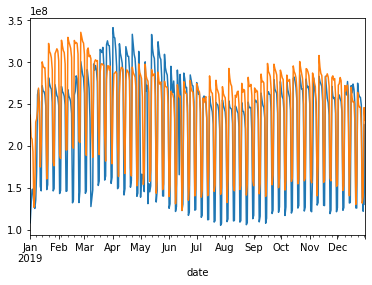

In [349]:
plt.figure()
#data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
data_nn_submition['value'].plot(kind = 'line')
plt.show()

In [252]:
mean_squared_error(data_test, data_nn_submition) / 365

21287656971310.227

In [330]:
prediction.to_csv('arima.csv', sep=',')